# Аспектный анализ тональности текстов: используем возможности fasttext

In [1]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)

## BIO-тэггинг для обучения модели

In [3]:
from dlnlputils.sentiment_utils import parse_xml_aspect, show_markup,prepare_data, generate_markup

In [4]:
from nltk.tokenize import RegexpTokenizer

word_tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

In [5]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
xml_train = 'datasets/sentirueval2015/SentiRuEval_car_markup_train.xml'
xml_test  = 'datasets/sentirueval2015/SentiRuEval_car_markup_test.xml'

In [6]:
texts_w_aspect_spans = parse_xml_aspect(xml_train)
texts_w_aspect_spans = [(text.lower(),spans) for text, spans in texts_w_aspect_spans]
training_data        = prepare_data(texts_w_aspect_spans, word_tokenizer.tokenize)

texts_w_aspect_spans = parse_xml_aspect(xml_test)
texts_w_aspect_spans = [(text.lower(),spans) for text, spans in texts_w_aspect_spans]
test_data            = prepare_data(texts_w_aspect_spans, word_tokenizer.tokenize)

In [7]:
len(training_data), len(test_data)

(2210, 1922)

In [8]:
test_recipe, test_tags = training_data[400]

text, spans = generate_markup(test_recipe, test_tags) 

show_markup(text, spans)

BoxMarkup('все так чисто , опрятно , светло и тепло , что я сразу же очутился в своей тарелке .',
          [Span(0, 15, 'Other'),
           Span(16, 23, 'Comfort'),
           Span(24, 84, 'Other')])

## Статистика по тэгам

In [9]:
from collections import Counter
from collections import defaultdict

def form_vocabulary_and_tagset(words_w_tags):
    dictionary = defaultdict(Counter)
    for words,tags in words_w_tags: 
        for word, tag in zip(words, tags):
            dictionary[tag].update([word])      
    return dictionary, set(dictionary.keys()) 

In [10]:
word_counter, labels = form_vocabulary_and_tagset(training_data)

In [11]:
for label in labels:
    num_words = len(word_counter[label])
    print(f'{num_words}\tin {label}')

49	in I-Safety
584	in B-Driveability
4933	in Other
60	in B-Safety
189	in B-Appearance
300	in I-Reliability
284	in I-Comfort
393	in I-Driveability
478	in B-Comfort
97	in I-Costs
200	in I-Whole
103	in I-Appearance
169	in B-Costs
236	in B-Whole
464	in B-Reliability


In [12]:
word_counter['I-Comfort'].most_common()#[-1]

[('в', 29),
 ('салоне', 17),
 ('места', 15),
 ('сиденья', 14),
 ('багажник', 12),
 ('сидений', 10),
 ('салона', 9),
 ('на', 8),
 ('для', 6),
 ('сидения', 5),
 ('багажника', 5),
 ('с', 5),
 ('и', 5),
 ('комплектации', 5),
 ('не', 5),
 ('автомобиля', 4),
 ('задние', 4),
 ('управления', 4),
 ('салон', 4),
 ('автомобиле', 3),
 ('тесно', 3),
 ('отделение', 3),
 ('передач', 3),
 ('фар', 3),
 ('стекло', 3),
 ('хватает', 3),
 ('приборов', 3),
 ('ног', 3),
 ('двери', 2),
 ('пластик', 2),
 ('авто', 2),
 ('машины', 2),
 ('колонка', 2),
 ('все', 2),
 ('пассажиров', 2),
 ('панели', 2),
 ('диване', 2),
 ('обслуживании', 2),
 ('заднем', 2),
 ('водителя', 2),
 ('от', 2),
 ('панель', 2),
 ('эксплуатации', 2),
 ('универсал', 2),
 ('-контроль', 2),
 ('передних', 2),
 ('потолок', 2),
 ('достаточно', 2),
 ('магнитолу', 2),
 ('удобно', 2),
 ('системы', 2),
 ('сидениях', 2),
 ('арок', 2),
 ('chery', 2),
 ('qq6', 2),
 ('1', 2),
 ('.1', 2),
 ('стучит', 2),
 ('безопасности', 2),
 ('"космо"', 1),
 ('руссифициров

In [13]:
class TagConverter():
    def __init__(self, tags):
        self.idx_to_tag  = sorted(tags)
        self.tag_to_idx  = {tag:idx for idx,tag in enumerate(self.idx_to_tag)}
        
    def tags_to_index(self, words):
        return torch.tensor([self.tag_to_idx[w] for w in words], dtype=torch.long)
    
    def indices_to_tags(self, indices):
        return [self.idx_to_tag[i] for i in indices]

In [14]:
tag_converter = TagConverter(labels)

In [15]:
test_recipe, test_tags = training_data[321]

# оригинал
text, spans = generate_markup(test_recipe, test_tags) 
show_markup(text, spans)

# кодируем только тэги:
encoded_tags = tag_converter.tags_to_index(test_tags)
print(encoded_tags)
print()

# декодируем тэги:
decoded_tags = tag_converter.indices_to_tags(encoded_tags)

text, spans = generate_markup(test_recipe, decoded_tags) 
show_markup(text, spans)

BoxMarkup('автомобиль принадлежит дяде .',
          [Span(0, 10, 'Whole'), Span(11, 29, 'Other')])

tensor([ 6, 14, 14, 14])



BoxMarkup('автомобиль принадлежит дяде .',
          [Span(0, 10, 'Whole'), Span(11, 29, 'Other')])

## fastText: забираем функции embedding слоя

In [16]:
import zipfile
import gensim
#import wget

model_url = 'http://vectors.nlpl.eu/repository/11/187.zip'
#wget.download(model_url)
model_file = 'datasets/' + model_url.split('/')[-1]

#### модель fasttext: редкие и  выдуманные слова

In [17]:
w2v_model = gensim.models.KeyedVectors.load('datasets/187/model.model')

In [18]:
words = ['тачаночка', 'двиганчик', 'ковервертолет']

for word in words:
    print(word)

    for i in w2v_model.most_similar(positive=[word], topn=10):
        nearest_word      = i[0]
        cosine_similarity = i[1]
        print(nearest_word, cosine_similarity)
    print('\n')

тачаночка
тачанка 0.7318679094314575
тачанк 0.6545170545578003
бричка 0.627240777015686
двуколка 0.610139012336731
тачка 0.5886926054954529
бараночка 0.5879709720611572
паночка 0.573016881942749
эмка 0.5701597929000854
саничка 0.565357506275177
каретка 0.5643386244773865


двиганчик
движка 0.4994381070137024
танчик 0.4963422417640686
двигай 0.4941864609718323
двигатели 0.48835229873657227
движа 0.4803929924964905
двигун 0.46693849563598633
движок 0.4630592465400696
моторчик 0.45433372259140015
шарк 0.4522787034511566
движ 0.452262818813324


ковервертолет
вертолет 0.743363618850708
ковер-самолет 0.6644095778465271
вертолетная 0.6616967916488647
вертолетчика 0.6364192962646484
вертолёт 0.6328296065330505
самолет 0.6245843768119812
ковре-самолет 0.6201825141906738
вертолетчик 0.6189783811569214
гидросамолет 0.6109312176704407
вертолетный 0.6071040630340576




Создадим конвертер слов в векторы fasttext:

In [19]:
class WordConverter:
    def __init__(self, w2v_model):
        self.w2v_model = w2v_model

    def convert(self, words):
        embeddings = [self.w2v_model.get_vector(word) for word in words]
        embeddings = torch.FloatTensor(embeddings)
        return embeddings

In [20]:
word_converter = WordConverter(w2v_model)

words,_ = training_data[333]
vectors = word_converter.convert(words)

vectors.shape

torch.Size([27, 300])

##  LSTM: теперь без embedding слоя

In [21]:
EMBEDDING_DIM = 300
HIDDEN_DIM    = 32
TAGSET_SIZE   = len(tag_converter.tag_to_idx)

In [22]:
class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, word_converter):
        super(LSTMTagger, self).__init__()
        tagset_size = len(tag_converter.tag_to_idx)
        
        self.word_converter = word_converter
        self.lstm           = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)
        self.hidden2tag     = nn.Linear(2*hidden_dim, output_dim)

    def forward(self, words):
        embeds      = self.word_converter.convert(words)
        lstm_out, _ = self.lstm(embeds.view(len(words), 1, -1))
        tag_space   = self.hidden2tag(lstm_out.view(len(words), -1))
        tag_scores  = F.log_softmax(tag_space, dim=1)
        return tag_scores
    
    def predict_tags(self, words):
        with torch.no_grad():
            tags_pred = model(words).numpy()
            tags_pred = np.argmax(tags_pred, axis=1)  
        return tags_pred

In [23]:
for label in labels:
    num_words = len(word_counter[label])
    print(f'{num_words}\tin {label}')

49	in I-Safety
584	in B-Driveability
4933	in Other
60	in B-Safety
189	in B-Appearance
300	in I-Reliability
284	in I-Comfort
393	in I-Driveability
478	in B-Comfort
97	in I-Costs
200	in I-Whole
103	in I-Appearance
169	in B-Costs
236	in B-Whole
464	in B-Reliability


In [24]:
from collections import Counter
from pprint import pprint

tag_counter = Counter()
for label in labels:
    tag_counter[label] = len(word_counter[label])
        
pprint(tag_counter.most_common())


class_weights = torch.ones(15)
class_divs    = torch.ones(15)

for tag, inv_weight in tag_counter.most_common():
    tag_idx             = tag_converter.tags_to_index([tag])
    class_divs[tag_idx] = inv_weight
    
norm       = torch.norm(class_divs, p=2, dim=0).detach()
class_divs = class_divs.div(norm.expand_as(class_divs))

class_weights /= class_divs

print(class_weights.detach())

[('Other', 4933),
 ('B-Driveability', 584),
 ('B-Comfort', 478),
 ('B-Reliability', 464),
 ('I-Driveability', 393),
 ('I-Reliability', 300),
 ('I-Comfort', 284),
 ('B-Whole', 236),
 ('I-Whole', 200),
 ('B-Appearance', 189),
 ('B-Costs', 169),
 ('I-Appearance', 103),
 ('I-Costs', 97),
 ('B-Safety', 60),
 ('I-Safety', 49)]
tensor([ 26.7865,  10.5913,  29.9565,   8.6689,  10.9109,  84.3775,  21.4519,
         49.1519,  17.8262,  52.1923,  12.8821,  16.8755, 103.3194,  25.3133,
          1.0263])


In [25]:
model         = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, TAGSET_SIZE, word_converter)
loss_function = nn.NLLLoss(class_weights) 
optimizer     = optim.SGD(model.parameters(), lr=0.1)

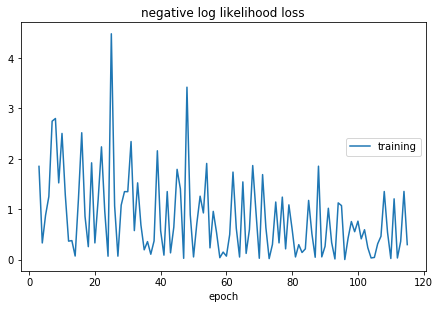

negative log likelihood loss:
training   (min:    0.006, max:    4.477, cur:    0.301)


In [26]:
from livelossplot import PlotLosses

liveplot = PlotLosses()

for epoch in range(5): 
    for i, (recipe, tags) in enumerate(training_data):
        
        model.zero_grad()
        
        tag_predicted = model(recipe) # <- теперь передаем предложение, а не список индексов слов
        tag_ground    = tag_converter.tags_to_index(tags) 
        
        
        loss = loss_function(tag_predicted, tag_ground)
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            liveplot.update({'negative log likelihood loss': loss})
            liveplot.draw()   

In [27]:
def predict_tags(model, recipe):
    encoded_tags   = model.predict_tags(recipe)      # предсказанные тэги (номера)
    decoded_tags   = tag_converter.indices_to_tags(encoded_tags) # номер тэга -> тэг
    return decoded_tags

In [28]:
for i in range(0,10):

    recipe, tags = test_data[np.random.randint(0,1000)]
    
    tags_pred    = predict_tags(model, recipe)

    print('истинные тэги:')
    text, spans = generate_markup(recipe, tags) 
    show_markup(text, spans)

    print('предсказанные тэги:')
    text, spans = generate_markup(recipe, tags_pred) 

    show_markup(text, spans)
    print()

истинные тэги:


BoxMarkup('и да , ходовые фары скручиваются минуты за три обе , у меня украли под окнами их , на видеозаписи видно , что скрутили их за 4 минуты .',
          [Span(0, 6, 'Other'),
           Span(7, 32, 'Safety'),
           Span(33, 59, 'Other'),
           Span(60, 77, 'Safety'),
           Span(78, 109, 'Other'),
           Span(110, 118, 'Safety'),
           Span(119, 135, 'Other')])

предсказанные тэги:


BoxMarkup('и да , ходовые фары скручиваются минуты за три обе , у меня украли под окнами их , на видеозаписи видно , что скрутили их за 4 минуты .',
          [Span(0, 6, 'Other'),
           Span(7, 19, 'Reliability'),
           Span(20, 32, 'Driveability'),
           Span(33, 59, 'Other'),
           Span(60, 66, 'Reliability'),
           Span(67, 70, 'Other'),
           Span(71, 77, 'Appearance'),
           Span(78, 135, 'Other')])


истинные тэги:


BoxMarkup('довольно таки просторный салон',
          [Span(0, 13, 'Other'), Span(14, 30, 'Comfort')])

предсказанные тэги:


BoxMarkup('довольно таки просторный салон',
          [Span(0, 13, 'Other'), Span(14, 30, 'Comfort')])


истинные тэги:


BoxMarkup('общее впечатление : приемлемая цена , но надо знать , что ...',
          [Span(0, 30, 'Other'), Span(31, 35, 'Costs'), Span(36, 61, 'Other')])

предсказанные тэги:


BoxMarkup('общее впечатление : приемлемая цена , но надо знать , что ...',
          [Span(0, 19, 'Other'), Span(20, 35, 'Costs'), Span(36, 61, 'Other')])


истинные тэги:


BoxMarkup('запчасти на нее не сильно дорогие , средняя цена тем более сейчас столько много магазинов на праворукие машины',
          [Span(0, 8, 'Costs'),
           Span(9, 15, 'Other'),
           Span(16, 33, 'Costs'),
           Span(34, 43, 'Other'),
           Span(44, 48, 'Costs'),
           Span(49, 92, 'Other'),
           Span(93, 110, 'Whole')])

предсказанные тэги:


BoxMarkup('запчасти на нее не сильно дорогие , средняя цена тем более сейчас столько много магазинов на праворукие машины',
          [Span(0, 8, 'Costs'),
           Span(9, 15, 'Other'),
           Span(16, 18, 'Costs'),
           Span(19, 25, 'Other'),
           Span(26, 52, 'Costs'),
           Span(53, 73, 'Other'),
           Span(74, 79, 'Comfort'),
           Span(80, 92, 'Other'),
           Span(93, 110, 'Whole')])


истинные тэги:


BoxMarkup('а вот аудиосистема штатная совсем плохая .',
          [Span(0, 5, 'Other'), Span(6, 26, 'Comfort'), Span(27, 42, 'Other')])

предсказанные тэги:


BoxMarkup('а вот аудиосистема штатная совсем плохая .',
          [Span(0, 5, 'Other'), Span(6, 26, 'Comfort'), Span(27, 42, 'Other')])


истинные тэги:


BoxMarkup('мотор', [Span(0, 5, 'Driveability')])

предсказанные тэги:


BoxMarkup('мотор', [Span(0, 5, 'Driveability')])


истинные тэги:


BoxMarkup('см .', [Span(0, 4, 'Other')])

предсказанные тэги:


BoxMarkup('см .', [Span(0, 4, 'Other')])


истинные тэги:


BoxMarkup('салон довольно просторный как для пассажиров так и для водителя .',
          [Span(0, 5, 'Comfort'),
           Span(6, 14, 'Other'),
           Span(15, 25, 'Comfort'),
           Span(26, 65, 'Other')])

предсказанные тэги:


BoxMarkup('салон довольно просторный как для пассажиров так и для водителя .',
          [Span(0, 5, 'Comfort'),
           Span(6, 14, 'Other'),
           Span(15, 25, 'Comfort'),
           Span(26, 33, 'Other'),
           Span(34, 44, 'Comfort'),
           Span(45, 65, 'Other')])


истинные тэги:


BoxMarkup('у jimny , несмотря на подключаемый полный привод не хватает элементарной мощности двигателя , чтоб преодолеть реальное бездорожье (я не говорю о ямах на дорогах и небольшом снежном покрове ).',
          [Span(0, 1, 'Other'),
           Span(2, 7, 'Driveability'),
           Span(8, 21, 'Other'),
           Span(22, 48, 'Driveability'),
           Span(49, 72, 'Other'),
           Span(73, 91, 'Driveability'),
           Span(92, 118, 'Other'),
           Span(119, 129, 'Driveability'),
           Span(130, 144, 'Other'),
           Span(145, 160, 'Driveability'),
           Span(161, 172, 'Other'),
           Span(173, 188, 'Driveability'),
           Span(189, 191, 'Other')])

предсказанные тэги:


BoxMarkup('у jimny , несмотря на подключаемый полный привод не хватает элементарной мощности двигателя , чтоб преодолеть реальное бездорожье (я не говорю о ямах на дорогах и небольшом снежном покрове ).',
          [Span(0, 21, 'Other'),
           Span(22, 34, 'Reliability'),
           Span(35, 59, 'Driveability'),
           Span(60, 72, 'Other'),
           Span(73, 91, 'Driveability'),
           Span(92, 118, 'Other'),
           Span(119, 129, 'Driveability'),
           Span(130, 144, 'Other'),
           Span(145, 160, 'Driveability'),
           Span(161, 191, 'Other')])


истинные тэги:


BoxMarkup('рассказывать об этом авто можно достаточно долго , но за такие деньги я бы купил иномарку',
          [Span(0, 20, 'Other'),
           Span(21, 25, 'Whole'),
           Span(26, 62, 'Other'),
           Span(63, 69, 'Costs'),
           Span(70, 80, 'Other'),
           Span(81, 89, 'Whole')])

предсказанные тэги:


BoxMarkup('рассказывать об этом авто можно достаточно долго , но за такие деньги я бы купил иномарку',
          [Span(0, 20, 'Other'),
           Span(21, 25, 'Whole'),
           Span(26, 62, 'Other'),
           Span(63, 69, 'Costs'),
           Span(70, 80, 'Other'),
           Span(81, 89, 'Whole')])

In [29]:
from dlnlputils.sentiment_utils import plot_confusion_matrix

In [30]:
y_pred = []
y_true = []

for sentence, tags in test_data:
    y_pred += predict_tags(model, sentence)
    y_true += tags

In [31]:
ordered_tags = [
 'Other',
 'B-Whole',
 'I-Whole',
 'B-Driveability',
 'I-Driveability',
 'B-Appearance',
 'I-Appearance',
 'B-Reliability',
 'I-Reliability',
 'B-Comfort',
 'I-Comfort',
 'B-Costs',
 'I-Costs',
 'B-Safety',
 'I-Safety']

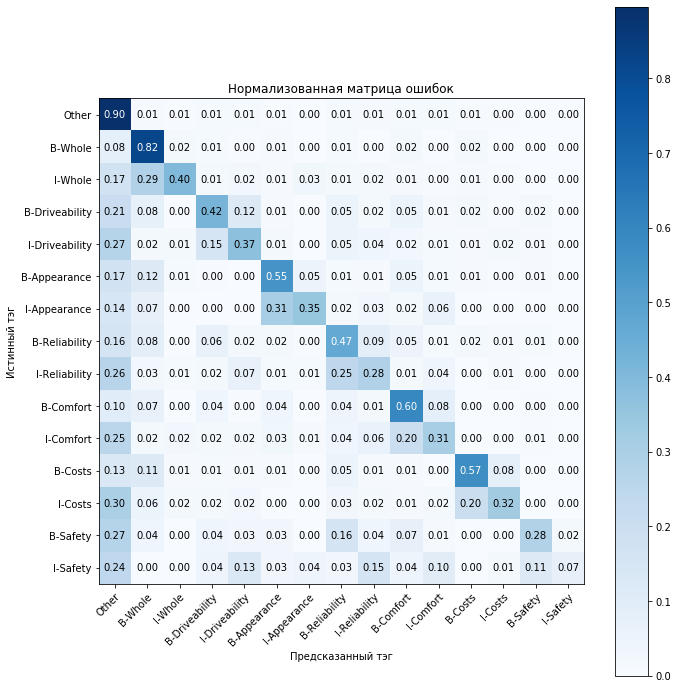

In [32]:
plot_confusion_matrix(y_true, y_pred, classes=ordered_tags, normalize=True, 
                      title='Нормализованная матрица ошибок')
plt.show()